<a href="https://colab.research.google.com/github/avionerman/computational_and_statistical/blob/main/CI%26SL3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [1]:

# Core scientific computing
import numpy as np
from numpy.linalg import eigh, eig, svd, norm, inv
from scipy.sparse import csr_matrix, diags, eye as sparse_eye
from scipy.sparse.linalg import eigsh, eigs
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.sparse.csgraph import shortest_path

# Machine Learning
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    confusion_matrix,
    accuracy_score
)
from sklearn.decomposition import PCA

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# utilities
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple
from enum import Enum, auto
import warnings
import time

warnings.filterwarnings('ignore')

# set random seeds for reproducibility for the rest of the code
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configuration attributes

In [2]:
@dataclass
class Config:

    # data
    sample_fraction: float = 0.10      # using x% of the data for faster experimenting
    normalize_method: str = 'minmax'   # avail options: 'minmax', 'standard'
    random_seed: int = 42

    # graph
    n_neighbors: int = 10 # k for kNN graph
    sigma: float = None   # gaussian kernel bandwidth (none = auto-estimate)

    # enable/disable methods
    enable_laplacian_eigenmaps: bool = True
    enable_lpp: bool = True
    enable_isomap: bool = True
    enable_lle: bool = True
    enable_tsne: bool = True

    # spectral settings
    n_clusters_list: List[int] = field(default_factory=lambda: [2, 3, 5, 7, 10])

    # tSNE only
    tsne_perplexity: float = 30.0
    tsne_n_iter: int = 1000


config = Config()

print(">>> Configuration set")
print(f"   Sample fraction: {config.sample_fraction * 100:.0f}%")
print(f"   n_neighbors: {config.n_neighbors}")
print(f"   Methods enabled: LE={config.enable_laplacian_eigenmaps}, LPP={config.enable_lpp}, "
      f"Isomap={config.enable_isomap}, LLE={config.enable_lle}, t-SNE={config.enable_tsne}")

>>> Configuration set
   Sample fraction: 10%
   n_neighbors: 10
   Methods enabled: LE=True, LPP=True, Isomap=True, LLE=True, t-SNE=True


# Data preprocessing

In [3]:
def load_mnist():
    from tensorflow.keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    class_names = [str(i) for i in range(10)]
    return x_train, y_train, x_test, y_test, class_names

def load_cifar10():
    from tensorflow.keras.datasets import cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    y_train, y_test = y_train.flatten(), y_test.flatten()
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    return x_train, y_train, x_test, y_test, class_names

def sample_data(x, y, fraction, random_seed=RANDOM_SEED):
    from sklearn.model_selection import train_test_split

    x_sample, _, y_sample, _ = train_test_split(
        x, y,
        train_size=fraction,
        stratify=y, # enable stratification for fair representation
        random_state=random_seed
    )
    return x_sample, y_sample

def preprocess_data(x, y, config):
    # sample, flatten, normalize to [0,1].

    x, y = sample_data(x, y, config.sample_fraction, config.random_seed)

    # flatten and normalize (images are 0-255 move under scale to 0-1)
    x_flat = x.reshape(len(x), -1).astype(np.float32) / 255.0

    return x_flat, y

# Data loading

In [4]:
# loading MNIST
print(">>> Loading MNIST")
x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist, mnist_classes = load_mnist()
x_mnist, y_mnist = preprocess_data(x_train_mnist, y_train_mnist, config)
print(f"MNIST: {x_mnist.shape[0]} samples, {x_mnist.shape[1]} features")

# loading CIFAR10
print(">>> Loading CIFAR10")
x_train_cifar, y_train_cifar, x_test_cifar, y_test_cifar, cifar_classes = load_cifar10()
x_cifar, y_cifar = preprocess_data(x_train_cifar, y_train_cifar, config)
print(f"CIFAR10: {x_cifar.shape[0]} samples, {x_cifar.shape[1]} features")

print(">>> Data loaded and preprocessed")

>>> Loading MNIST
MNIST: 6000 samples, 784 features
>>> Loading CIFAR10
CIFAR10: 5000 samples, 3072 features
>>> Data loaded and preprocessed


# Datasets visualization

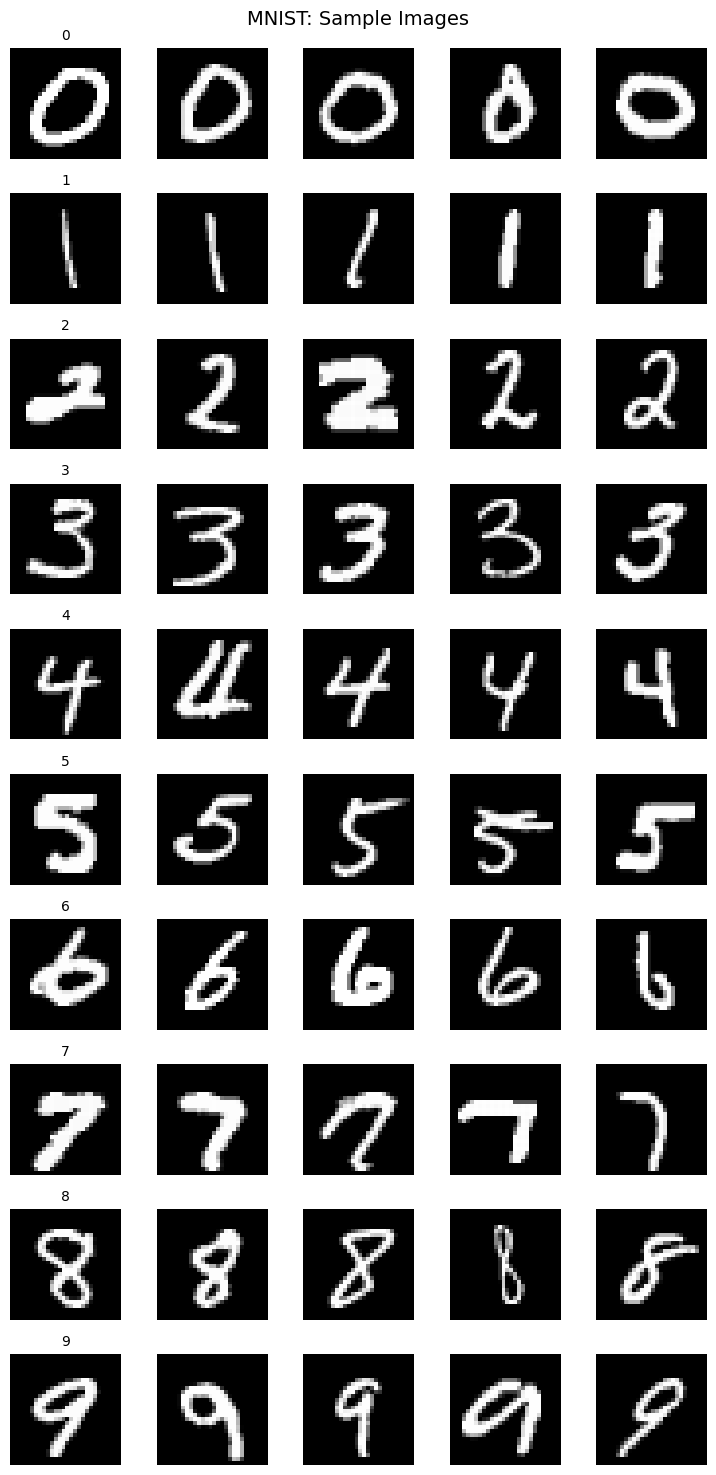

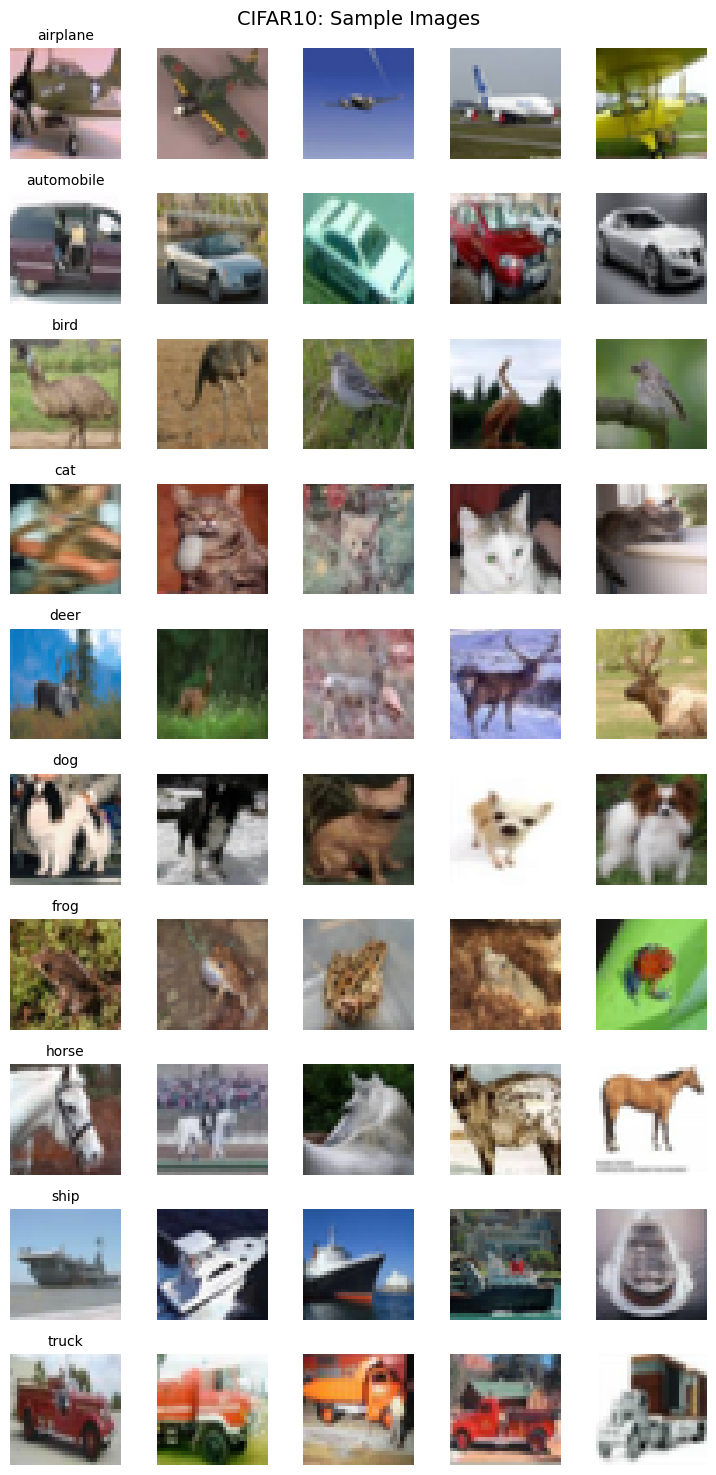

In [5]:
def visualize_samples(x_original, y, class_names, dataset_name, n_samples=5):
    # present sample images from each class
    n_classes = len(class_names)
    fig, axes = plt.subplots(n_classes, n_samples, figsize=(n_samples * 1.5, n_classes * 1.5))
    fig.suptitle(f'{dataset_name}: Sample Images', fontsize=14)

    for row, cls in enumerate(range(n_classes)):
        # get images of this class
        cls_indices = np.where(y == cls)[0]
        selected = np.random.choice(cls_indices, size=n_samples, replace=False)

        for col, idx in enumerate(selected):
            ax = axes[row, col]
            img = x_original[idx]

            # handling grayscale (MNIST) vs rbg (CIFAR10)
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)

            ax.axis('off')
            if col == 0:
                ax.set_title(class_names[cls], fontsize=10)

    plt.tight_layout()
    plt.show()



visualize_samples(x_train_mnist, y_train_mnist, mnist_classes, 'MNIST')
print("\n\n")
visualize_samples(x_train_cifar, y_train_cifar, cifar_classes, 'CIFAR10')

# Graph creation

In [6]:
def build_knn_graph(x, n_neighbors):
    """
    finds k nearest neighbors for each point
    returning symmetric binary adjacency matrix
    mode -> connectivity: matrix should be binary (1: connection, 0: no connection)
    include_self: ensures a point is not considered its own neighbor
    """
    knn = kneighbors_graph(x, n_neighbors, mode='connectivity', include_self=False)

    # symmetric transformation:
    # if there's an edge from i to j or from j to i
    # it will be present in adjacency
    adjacency = knn + knn.T

    # if both i is neighbor of j and j is neighbor of i, then the entry will be 2
    # so I convert them to 1, or I keep them as 0 if it's 0 already
    adjacency = (adjacency > 0).astype(np.float64)

    return adjacency.toarray()

def compute_gaussian_weights(x, adjacency, sigma=None):
    """
    converts distances to similarities using Gaussian kernel
    compute Gaussian kernel weights (used formula from pdf)
    W_ij = exp(-||x_i - x_j||^2 / (2 * sigma^2))
    """
    distances = cdist(x, x, 'euclidean')

    # estimate sigma IF not provided (median)
    if sigma is None:

      # considers distances between points that are k nearest neighbors
        connected_distances = distances[adjacency > 0]

        # if sigma is none, will be calculated using distances' median
        sigma = np.median(connected_distances)

    # closer to 1: better similarity
    # closer to 0, the opposite
    W = np.exp(-distances**2 / (2 * sigma**2))

    # all the entries (where adjacency is 0) become 0
    # meaning non-neighbors have zero similarity
    W = W * adjacency
    np.fill_diagonal(W, 0)

    return W, sigma

def build_similarity_graph(x, n_neighbors, sigma=None):
    """
    combines both steps + computes degree matrix
    and then building complete similarity graph
    returning W (matrix), D (matrix) and which sigma used
    """
    adjacency = build_knn_graph(x, n_neighbors)
    W, sigma = compute_gaussian_weights(x, adjacency, sigma)
    D = np.diag(W.sum(axis=1))  # degree matrix

    return W, D, sigma

# Method 1: Laplacian Eigenmap [LE]

In [7]:
def laplacian_eigenmaps(x, n_components=2, n_neighbors=15, sigma=None):
    """
    Laplacian Eigenmaps for dimensionality reduction:

    1. building similarity graph (W and D)
    2. calculating Laplacian L = D - W
    3. normalization with L_rows = D^(-1) @ L
    4. finding the actual eigenvectors
    5. returnin at the end the 2nd to (n_components+1)th eigenvectors
    """
    # 1: building similarity graph
    W, D, sigma = build_similarity_graph(x, n_neighbors, sigma)

    # 2: calculating Laplacian
    L = D - W

    # 3: normalization with (L_rows = D^(-1) @ L)

    # small value to avoid division by zero
    D_inv = np.diag(1.0 / (np.diag(D) + 1e-10))
    L_rows = D_inv @ L

    # 4: finding the actual eigenvectors
    eigenvalues, eigenvectors = eigh(L_rows)

    # sorting by eigenvalue and skip the first eigenvector (useless)
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # 5: returnin at the end the 2nd to (n_components+1)th eigenvectors
    embedding = eigenvectors[:, 1:n_components + 1]

    return embedding, eigenvalues


print(">>> Laplacian Eigenmaps executed")

>>> Laplacian Eigenmaps executed


# Method 2: Locality Preserving Projections [LPP]

In [17]:
def lpp(x, n_components=2, n_neighbors=15, sigma=None):
    """
    LPP - Linear approximation of Laplacian Eigenmaps

    key difference from LE:
    - LE gives embedding (positions)
    - LPP gives projection matrix (can project NEW data!)

    I want to solve the X @ L @ X.T @ w = λ @ X @ D @ X.T @ w
    formula was used after reading the following paper:
    https://proceedings.neurips.cc/paper/2003/file/d69116f8b0140cdeb1f99a4d5096ffe4-Paper.pdf
    """
    from scipy.linalg import eigh as scipy_eigh

    n_samples, n_features = x.shape

    # 1: building similarity graph (same as LE but for LPP this time)
    W, D, sigma = build_similarity_graph(x, n_neighbors, sigma)

    # 2: calculating Laplacian
    L = D - W

    # 3: calculating scatter matrices
    # X.T has shape (features, samples)
    # XLXT has shape (features, features)
    XLXT = x.T @ L @ x # (784, 784) - what relation exists through Laplacian
    XDXT = x.T @ D @ x # w will be (784,) a weight per feature - what relation exists through connectivity

    # 4: regularization (avoid singular matrix)
    # np.trace(XDXT) = sum of all diagonal elements (matrix size)
    reg = 1e-6 * np.trace(XDXT) / n_features # dividing with n_features to get the avg
    XDXT_reg = XDXT + reg * np.eye(n_features) # append to the diagonal

    # 5: fix generalized eigenvalue problem
    # scipy_eigh() is finding the values and vectors of an eigen
    # A*v = λ*B*v using this formula
    # vectors are the projection weights
    # values are the numbers telling me how good each weight is
    eigenvalues, eigenvectors = scipy_eigh(XLXT, XDXT_reg)

    # 6: find eigenvalues that are NOT near zero (skip meaningless ones)
    threshold = 1e-10
    valid_idx = np.where(eigenvalues > threshold)[0]

    # sort the valid eigenvalues (smallest first)
    valid_eigenvalues = eigenvalues[valid_idx]
    sorted_valid_idx = valid_idx[np.argsort(valid_eigenvalues)]

    # picks the 2 eigenvector columns that have the smallest VALID eigenvalues (2D)
    projection_matrix = eigenvectors[:, sorted_valid_idx[:n_components]]

    # 7: data projection
    """
            x                  projection_matrix                embedding
    | 15000 images    |       |   784 weights   |     =  | 15000 points in 2D |
    |                 |   X   |                 |        |                    |
    | with 784 pixels |       | for each of 2D  |        | (x, y) coordinates |
    """
    embedding = x @ projection_matrix

    return embedding, projection_matrix, eigenvalues


def lpp_project_new_data(x_new, projection_matrix):
    """
    projecting new data using learned LPP projection matrix - big diff from LE that needs to recalculate
    """
    return x_new @ projection_matrix


print(">>> LPP executed!")

>>> LPP executed!
